# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [113]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import  KFold
import numpy as np

In [114]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for All Players')

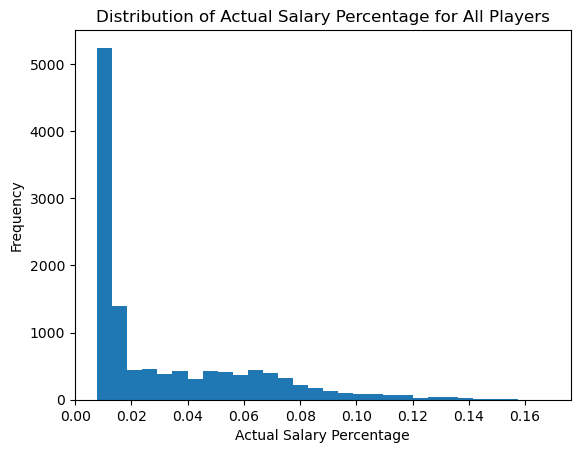

In [115]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(data['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for All Players')

In [117]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [111]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]

# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0004995167175455405


In [118]:
# Assuming 'test_train_data' and 'numerical_features' are defined as in your script
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01)

# Define the pipeline as before
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross-validation for automated feature selection
# Set min_features_to_select to 1 to ensure at least one feature is selected
# cv=n for n-fold cross-validation
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(2), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')

Mean Squared Error: 0.0005020176309511971
Optimal number of features : 103


In [130]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

Training performance score: -0.8239637084049871
Testing performance score: -0.93738473880002


/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [119]:
# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# # If you have a large number of features and only want to see the top ones, you can slice the list
# print("Top 10 most important features:")
# for feature, importance in sorted_importances[:10]:
#     print(f"{feature}: {importance}")

MDCA/GP: 0.21092374622821808
CF/GP: 0.1164182499051094
PENALTIES DRAWN/60: 0.09480378776788712
TOI/GP: 0.04835670068860054
FA/GP: 0.01502043567597866
TAKEAWAYS/60: 0.013842768967151642
TOTAL PENALTIES/60: 0.012691131792962551
SCF/GP: 0.010843898169696331
MDGA/GP: 0.009950127452611923
FIRST ASSISTS/GP: 0.009912303648889065
MINOR/60: 0.00989578478038311
HITS/GP: 0.008597580716013908
MAJOR/GP: 0.008358184248209
SECOND ASSISTS/GP: 0.008144786581397057
IHDCF/GP: 0.007673241198062897
LDGA/GP: 0.007613929454237223
MAJOR/60: 0.007479581516236067
IHDCF/60: 0.006856745574623346
ICF/60: 0.006843089126050472
FF/60: 0.00658009247854352
TAKEAWAYS/GP: 0.006570766679942608
FACEOFFS WON/GP: 0.006479861680418253
NEU. ZONE STARTS/GP: 0.006450459361076355
MDGF/60: 0.006388999987393618
RUSH ATTEMPTS/GP: 0.006213664542883635
HDGA/GP: 0.006121779792010784
REBOUNDS CREATED/GP: 0.006003209855407476
IXG/60: 0.005975973326712847
HITS TAKEN/60: 0.005922412034124136
SHOTS/60: 0.005891142413020134
MDGF/GP: 0.005736

In [120]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [121]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [122]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
952,alex ovechkin,2009-10,"$9,538,462.00","$9,478,640.00","$-59,822.00",0.166877
424,alex ovechkin,2008-09,"$9,538,462.00","$9,436,519.00","$-101,943.00",0.166429
2812,alex ovechkin,2012-13,"$9,538,462.00","$9,308,294.00","$-230,168.00",0.155138
9143,connor mcdavid,2020-21,"$12,500,000.00","$12,023,759.00","$-476,241.00",0.147531
1141,evgeni malkin,2009-10,"$8,700,000.00","$8,373,501.00","$-326,499.00",0.147421
881,sidney crosby,2008-09,"$8,700,000.00","$8,320,023.00","$-379,977.00",0.146738
1454,sidney crosby,2009-10,"$8,700,000.00","$8,321,147.00","$-378,853.00",0.146499
41,brad richards,2007-08,"$7,800,000.00","$7,333,830.00","$-466,170.00",0.145802
11910,nathan mackinnon,2023-24,"$12,600,000.00","$12,141,689.00","$-458,311.00",0.145409
9045,auston matthews,2020-21,"$11,640,250.00","$11,681,973.00","$41,723.00",0.143337


In [123]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,"$3,775,000.00","$1,999,104.00","$-1,775,896.00",0.027999
6071,connor mcdavid,2016-17,"$3,775,000.00","$6,524,657.00","$2,749,657.00",0.089379
6841,connor mcdavid,2017-18,"$3,775,000.00","$2,270,037.00","$-1,504,963.00",0.030267
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,378,044.00","$-1,121,956.00",0.143120
8398,connor mcdavid,2019-20,"$12,500,000.00","$11,406,243.00","$-1,093,757.00",0.139954
9143,connor mcdavid,2020-21,"$12,500,000.00","$12,023,759.00","$-476,241.00",0.147531
9952,connor mcdavid,2021-22,"$12,500,000.00","$10,528,320.00","$-1,971,680.00",0.129182
10786,connor mcdavid,2022-23,"$12,500,000.00","$11,773,932.00","$-726,068.00",0.142714
11570,connor mcdavid,2023-24,"$12,500,000.00","$10,767,912.00","$-1,732,088.00",0.128957


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Forwards')

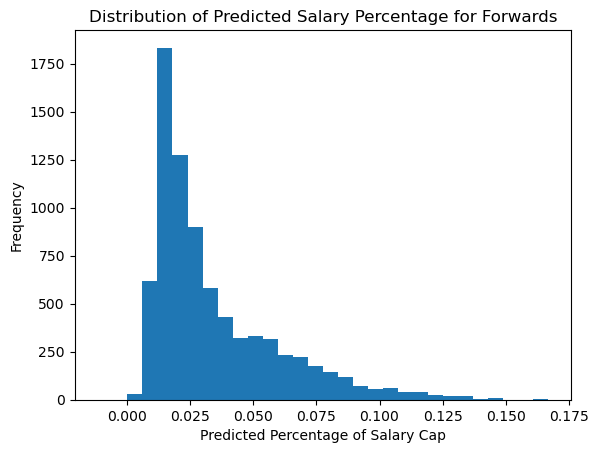

In [124]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Percentage of Salary Cap')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Forwards')

Text(0.5, 1.0, 'Actual Distribution of Salary Cap Percentage for Forwards')

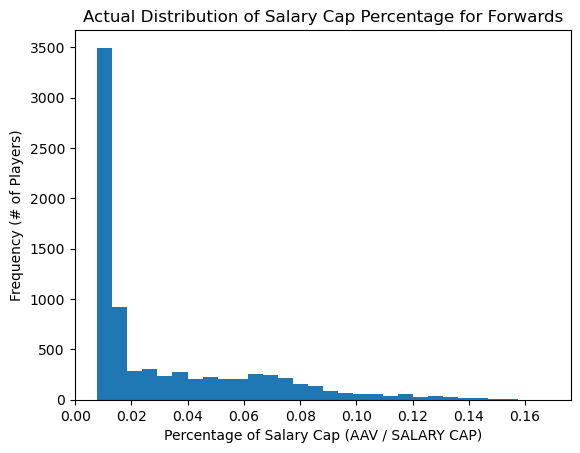

In [125]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Percentage of Salary Cap (AAV / SALARY CAP)')
plt.ylabel('Frequency (# of Players)')
plt.title('Actual Distribution of Salary Cap Percentage for Forwards')

In [126]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12045,"mtl, wpg",sean monahan,2023-24,"$2,000,000.00","$5,454,856.00","$3,454,856.00",0.065328,3454856.0
11701,bos,james van riemsdyk,2023-24,"$1,000,000.00","$4,177,675.00","$3,177,675.00",0.050032,3177675.0
11539,"buf, col",casey mittelstadt,2023-24,"$2,500,000.00","$5,507,417.00","$3,007,417.00",0.065957,3007417.0
11851,car,martin necas,2023-24,"$3,000,000.00","$5,410,505.00","$2,410,505.00",0.064796,2410505.0
11975,chi,philipp kurashev,2023-24,"$2,250,000.00","$4,648,618.00","$2,398,618.00",0.055672,2398618.0
11917,ari,nick bjugstad,2023-24,"$2,100,000.00","$4,298,682.00","$2,198,682.00",0.051481,2198682.0
12070,chi,taylor raddysh,2023-24,"$758,333.00","$2,863,985.00","$2,105,652.00",0.034299,2105652.0
11754,col,jonathan drouin,2023-24,"$825,000.00","$2,823,401.00","$1,998,401.00",0.033813,1998401.0
12133,dal,wyatt johnston,2023-24,"$1,000,417.00","$2,948,020.00","$1,947,603.00",0.035306,1947603.0
11842,min,marcus johansson,2023-24,"$2,000,000.00","$3,806,736.00","$1,806,736.00",0.045590,1806736.0


In [127]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12136,sea,yanni gourde,2023-24,"$5,166,666.00","$4,047,162.00","$-1,119,504.00",0.048469,-1119504.0
12004,dal,roope hintz,2023-24,"$8,450,000.00","$7,320,089.00","$-1,129,911.00",0.087666,-1129911.0
11762,stl,jordan kyrou,2023-24,"$8,125,000.00","$6,854,486.00","$-1,270,514.00",0.082090,-1270514.0
11505,mtl,brendan gallagher,2023-24,"$6,500,000.00","$5,190,915.00","$-1,309,085.00",0.062167,-1309085.0
11574,van,conor garland,2023-24,"$4,950,000.00","$3,580,722.00","$-1,369,278.00",0.042883,-1369278.0
11423,fla,aleksander barkov,2023-24,"$10,000,000.00","$8,618,593.00","$-1,381,407.00",0.103217,-1381407.0
11425,det,alex debrincat,2023-24,"$7,875,000.00","$6,400,871.00","$-1,474,129.00",0.076657,-1474129.0
11725,car,jesperi kotkaniemi,2023-24,"$4,820,000.00","$3,320,647.00","$-1,499,353.00",0.039768,-1499353.0
12122,"fla, ott",vladimir tarasenko,2023-24,"$5,000,000.00","$3,395,127.00","$-1,604,873.00",0.040660,-1604873.0
11721,buf,jeff skinner,2023-24,"$9,000,000.00","$7,338,338.00","$-1,661,662.00",0.087884,-1661662.0


In [128]:
filtered_data[filtered_data['PLAYER'] == 'leon draisaitl'][display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
11810,leon draisaitl,2023-24,"$8,500,000.00","$8,921,306.00","$421,306.00",0.106842


In [48]:
predictions = pd.DataFrame(forwards[['PLAYER', 'SEASON', 'TOI/GP', 'PRED_SALARY_PERCENTAGE']])

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'forwards_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=False)